<a href="https://colab.research.google.com/github/tassiLuca/dia-project/blob/master/fetal_health_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fetal Health Classification
## Progetto d'Esame di _Applicazioni di Data Intensive_
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

**Luca Tassinari** • **luca.tassinari10@studio.unibo.it**

## TODO

1. encoding su variabile categorica ?
2. Outliers?
3. class weight




In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
import os
from urllib.request import urlretrieve
def download(file, url):
    ''' A simple function to download, from a given url, a file. '''
    if not os.path.isfile(file):
        urlretrieve(url, file)

## Introduzione al caso di studio
### Contesto
La riduzione della mortalità infatile è uno degli [obiettivi](https://www.eda.admin.ch/agenda2030/it/home/agenda-2030/die-17-ziele-fuer-eine-nachhaltige-entwicklung/ziel-3--ein-gesundes-leben-fuer-alle-menschen-jeden-alters-gewae.html) di sviluppo sostenibile delle Nazioni Unite e, sicuramente, uno dei grandi indicatori del progresso umano.

In questo contesto, la cardiotocografia è un esame poco invasivo che viene effettuato durante il periodo prenatale e che, grazie a un trasduttore a ultrasuoni, permette di monitorare la frequenza cardiaca fetale (FHR), i movimenti fetali, le contrazioni uterine e altro ancora.

### I dati
Lo scopo è riuscire a creare un algoritmo di **classificazione** che permetta di identificare i bimbi a rischio e quelli in condizioni patologiche.
Per farlo si usa un dataset scaricato da [kaggle](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification) in cui 2126 registrazioni delle caratteristiche estratte dalle cardiotocografie sono state classificate da tre ostretici esperti in 3 classi:
- Normale
- Sospetto
- Patologico

In [53]:
download("data.csv.gz", "https://github.com/tassiLuca/dia-project/raw/master/datasets/fetal_health.csv.gz")

In [54]:
data = pd.read_csv("data.csv.gz", compression="gzip")

In [55]:
# by default pandas displays only 20 cols
pd.options.display.max_columns = len(data.columns)

Vengono qui riportate le descrizioni delle 22 _feature_ del dataset:
- `baseline value` (numerica): Baseline Fetal Heart Rate (FHR);
- `accelerations` (numerica): Number of accelerations per second;
- `fetal_movement` (numerica): Number of fetal movements per second; 
- `uterine_contractions` (numerica): Number of uterine contractions per second;
- `light_decelerations` (numerica): Number of LDs per second;
- `severe_decelerations` (numerica): Number of SDs per second;
- `prolongued_decelerations` (numerica): Number of PDs per second;
- `abnormal_short_term_variability` (numerica): Percentage of time with abnormal short term variability;
- `mean_value_of_short_term_variability` (numerica): Mean value of short term variability;
- `percentage_of_time_with_abnormal_long_term_variability` (numerica): Percentage of time with abnormal long term variability;
- `mean_value_of_long_term_variability` (numerica): Mean value of long term variability;
- `histogram_width` (numerica): Width of the histogram made using all values from a record;
- `histogram_min` (numerica): Histogram minimum value;
- `histogram_max` (numerica): Histogram maximum value;
- `histogram_number_of_peaks` (numerica) : Number of peaks in the exam histogram;
- `histogram_number_of_zeroes` (numerica): Number of zeroes in the exam histogram;
- `histogram_mode` (numerica): Hist mode;
- `histogram_mean` (numerica): Hist mean;
- `histogram_median` (numerica): Hist median;
- `histogram_variance` (numerica): Hist variance;
- `histogram_tendency` (categorica): Histogram trend;
- **`fetal_health`: to predict**
    - 0: Normal
    - 1: Suspect
    - 2: Pathological

In [56]:
data

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,7.2,40.0,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,7.1,66.0,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,6.1,67.0,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,7.0,66.0,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


## Analisi esplorativa dei dati

Definiamo un dizionario per mappare le tre classi (1, 2, 3) in una descrizione più leggibile e in tre colori differenti (ci servirà più tardi per i grafici):

In [57]:
diagnosis_desc = {1.0: "normale", 2.0: "sospetto", 3.0: "patologico"}

In [58]:
diagnosis_color_map = {1.0: "green", 2.0: "orange", 3.0: "red"}

In [59]:
diagnosis_colors = data["fetal_health"].map(diagnosis_color_map)

Come si può notare tutte le _features_ del dataset sono numeriche, tranne che per `histogram_tendency` che può assumere 3 valori 0, 1 e -1:

In [60]:
data["histogram_tendency"].value_counts()

 0.0    1115
 1.0     846
-1.0     165
Name: histogram_tendency, dtype: int64

Visualizziamo la distribuzione dei dati nel dataset, attraverso un semplice grafico a torta.

In [61]:
dd = data["fetal_health"].map(diagnosis_desc).value_counts().to_frame(name="count")
dd["%"] = (dd["count"] / len(data)) * 100
dd

,count,%
normale,1655,77.845720
sospetto,295,13.875823
patologico,176,8.278457


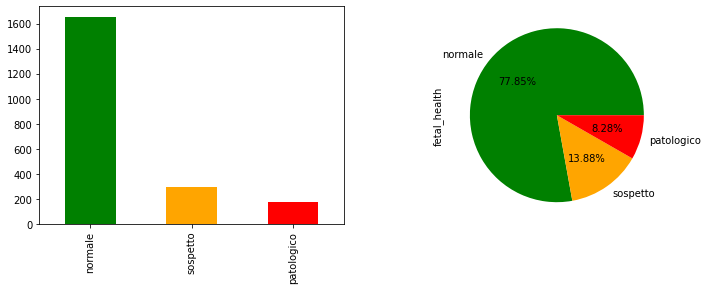

In [62]:
plt.figure(figsize=(12, 4))
data["fetal_health"].map(diagnosis_desc).value_counts().plot.bar(
    ax=plt.subplot(1, 2, 1),
    color=list(diagnosis_color_map.values())
)
data["fetal_health"].map(diagnosis_desc).value_counts().plot.pie(
    autopct="%.2f%%",
    ax=plt.subplot(1, 2, 2), 
    colors=list(diagnosis_color_map.values())
)

Come si può osservare, il 78% delle osservazioni del dataset sono state classificate come normali, il 14% come sospette e circa l'8% come patologiche. Su un totale di 2126 osservazioni, quindi, appena 176 sono state classificate come casi patologici e solo 295 come casi sospetti.

Siamo quindi in presenza di un dataset in cui la suddivisione di istanze tra le classi è molto **sbilanciata**. Questo può portare a molti più errori di classificazione sulla classe meno rappresentata - che nel caso in esame è proprio la classe più importante da predire - e a fornire stime di accuratezza fuorvianti. Per questo sarà fondamentale, nel seguito, adottare stime di accuratezza più raffinate (quali la _Precision_, _Recall_, _F1 Score_) e metodi per cercare di ridurre questo problema.

Statistiche per ogni _feature_:

In [63]:
stats = data.iloc[:, :-1].describe()
#                    ^^^^
# exclude the last col which contains the target

In [64]:
stats

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,8.187629,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,5.628247,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,4.600000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,7.400000,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,10.800000,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,50.700000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000


Grafichiamo con dei _boxplot_ i dati per vedere se ci sono _outliers_. Si ricorda che gli estremi inferiore e superiore di ciascun rettangolo rappresentano il primo ($Q_1$) e terzo quartile ($Q_3$) (rispettivamente 25° e 75° percentile) dei dati e la linea centrale è la mediana. I cerchi molto distanti dalla mediana sono detti _outlier_: tutti quei valori $x$ t.c. $$x < Q_1 - 1,5 \cdot IQR \lor x > Q_3 + 1,5 \cdot IQR $$ dove $IQR = Q_3 - Q_1$

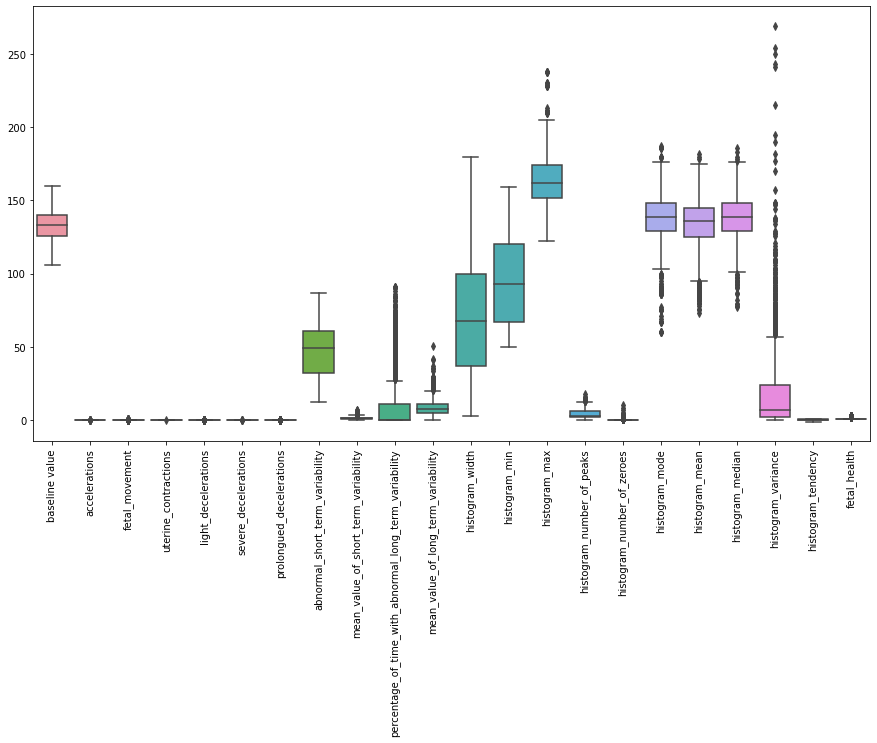

In [66]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=data)
plt.xticks(rotation=90)
plt.show()

Nonostante siano presenti valori anomali nel dataset (i.e. _outliers_), si ritiene opportuno **non** eliminarli: il dataset sopra presentato è il frutto di un rapporto CTG in cui ciascuna osservazione è stata etichettata da esperti, per cui si ritiene improbabile un errore di immissione dei dati, bensì siano proprio queste osservazioni anomale ad essere rappresentative per il caso di studio.

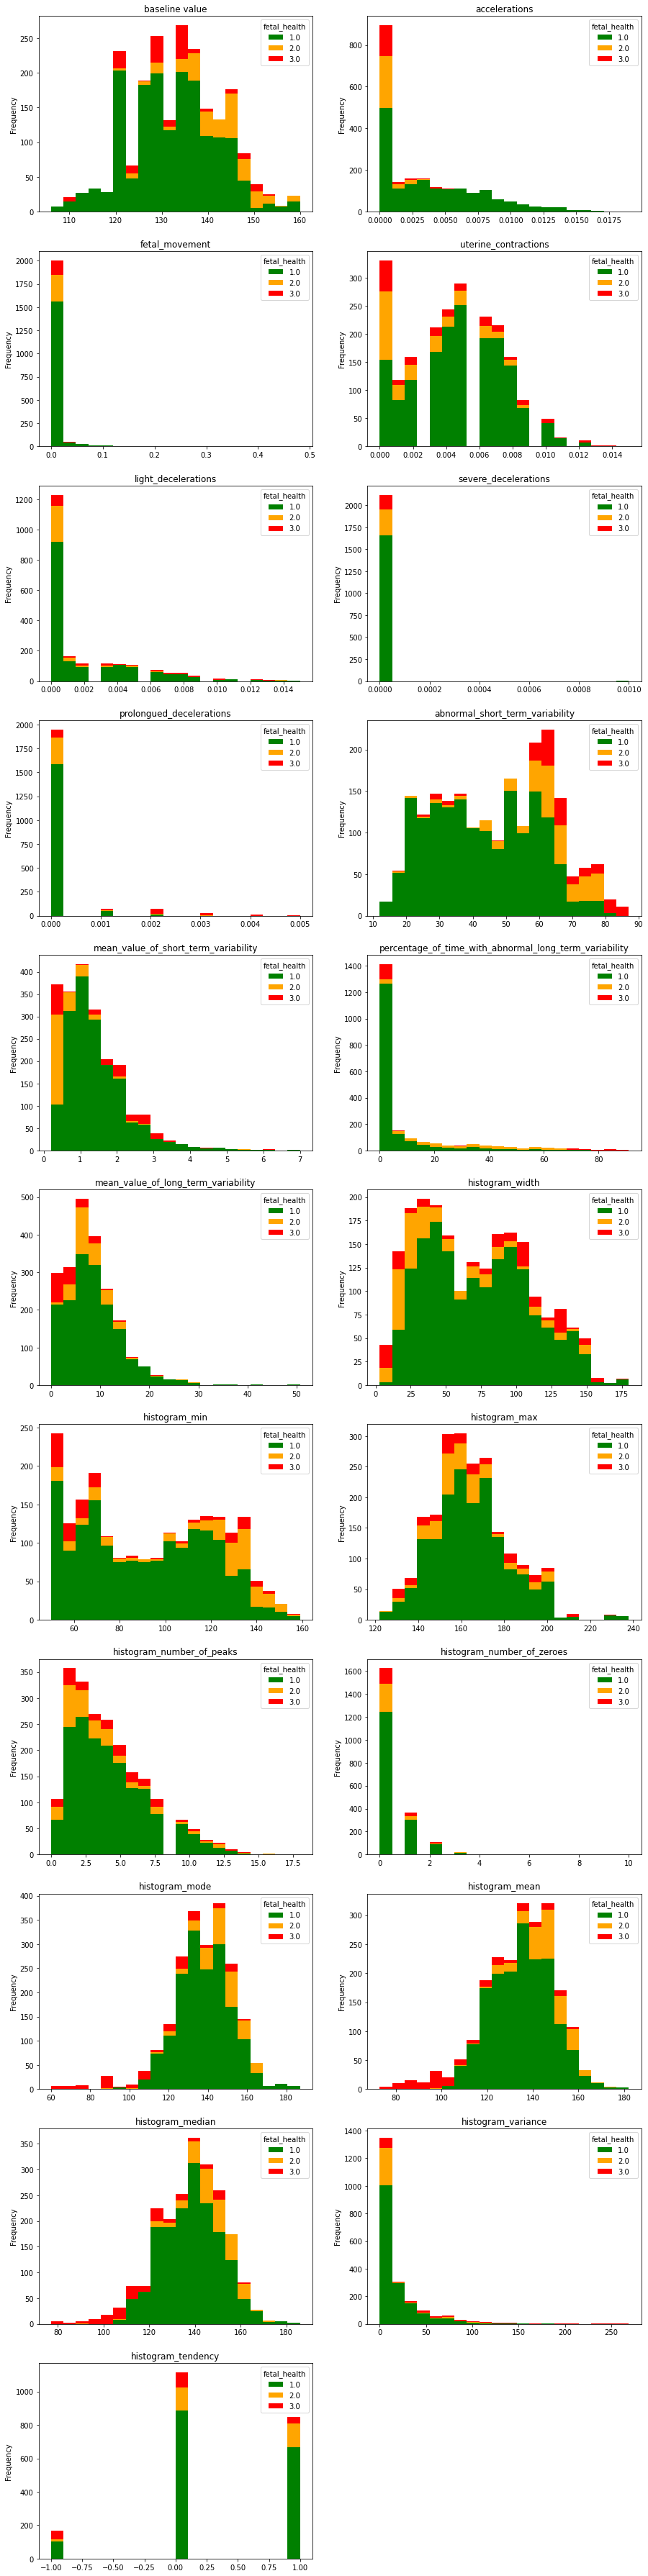

In [67]:
plt.figure(figsize=(15, 65))
for col, i in zip(data.columns[:-1], range(len(data.columns[:-1]))):
    data.pivot(columns="fetal_health")[col].plot.hist(
        bins=20, 
        stacked=True, 
        title=col, 
        ax=plt.subplot(11, 2, i+1),
        color=list(diagnosis_color_map.values())
    )

Appare evidente una relazione tra la variabile target e le feature:
- `abnormal_short_tem_variability`
...

Calcoliamo la correlazione di ciascuna feature con ciascuna possibile diagnosi con il metodo Pearson

In [68]:
from sklearn.preprocessing import OneHotEncoder

In [69]:
encoder = OneHotEncoder(sparse = False)
target_variables = pd.DataFrame(
    encoder.fit_transform(data[["fetal_health"]]),
    columns=encoder.get_feature_names_out()
)

In [70]:
target_variables

,fetal_health_1.0,fetal_health_2.0,fetal_health_3.0
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
2121,0.0,1.0,0.0
2122,0.0,1.0,0.0
2123,0.0,1.0,0.0
2124,0.0,1.0,0.0


In [71]:
data_combo = data.join(target_variables)
data_combo.drop(columns=["fetal_health"])
data_combo

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,...,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health,fetal_health_1.0,fetal_health_2.0,fetal_health_3.0
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,...,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0,0.0,1.0,0.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,...,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0,1.0,0.0,0.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,...,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0,1.0,0.0,0.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,...,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0,1.0,0.0,0.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,...,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,7.2,...,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0,0.0,1.0,0.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,7.1,...,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0,0.0,1.0,0.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,6.1,...,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0,0.0,1.0,0.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,7.0,...,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0,0.0,1.0,0.0


In [72]:
data_corr = data_combo.corr(method='pearson')

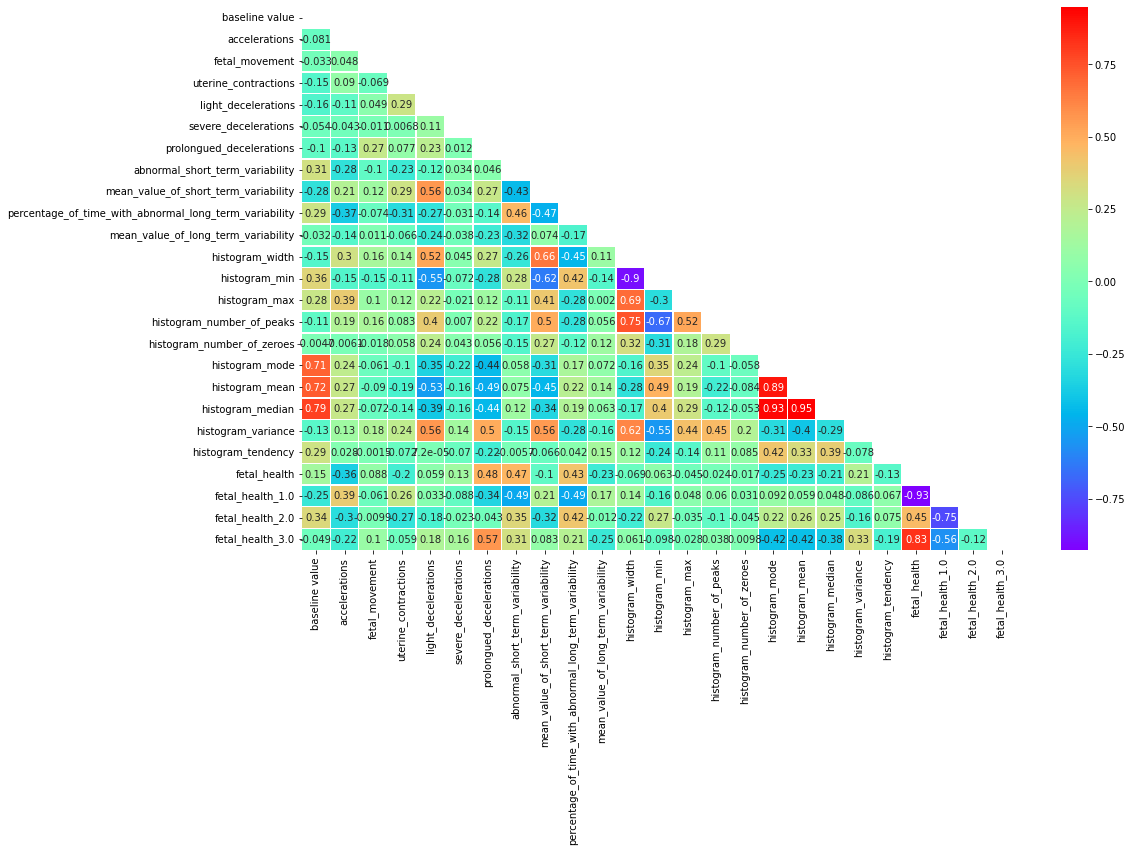

In [73]:
mask = np.zeros_like(data_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(16, 10))
sns.heatmap(data_corr, mask=mask, cmap="rainbow", linewidths=0.30, annot=True)

Come si può vedere vi è correlazione tra `prolungued_decelerations`, `abnormal_short_term_variability`, `percentage_of_time_with_abnormal_long_term_variability`.

In [74]:
x = data_corr[list(encoder.get_feature_names_out())].sort_values(
    list(encoder.get_feature_names_out()), ascending=False)
x = x.drop(list(encoder.get_feature_names_out()) + ["fetal_health"], axis=0)
x.style.background_gradient(cmap="rainbow")

,fetal_health_1.0,fetal_health_2.0,fetal_health_3.0
accelerations,0.394760,-0.301581,-0.216591
uterine_contractions,0.263639,-0.269365,-0.059397
mean_value_of_short_term_variability,0.207717,-0.315373,0.082600
mean_value_of_long_term_variability,0.172519,-0.011522,-0.245545
histogram_width,0.142182,-0.219384,0.060945
histogram_mode,0.092320,0.223125,-0.419051
histogram_tendency,0.066529,0.074653,-0.193919
histogram_number_of_peaks,0.060354,-0.102957,0.038205
histogram_mean,0.059107,0.261298,-0.416886
histogram_max,0.048106,-0.035153,-0.028399


Infatti:

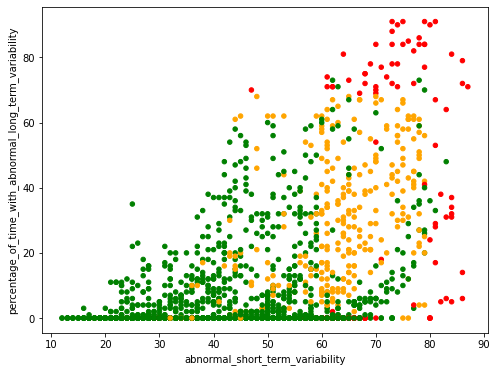

In [75]:
data.plot.scatter("abnormal_short_term_variability", "percentage_of_time_with_abnormal_long_term_variability", c=diagnosis_colors, figsize=(8, 6));

## CLASSIFICAZIONE LINEARE

Definiamo alcune funzioni di supporto per calcolare e stampare a le statistiche di accuratezza

In [76]:
def conf_interval(a, N, Z=1.96):
    '''
    Computes the confidence interval.
    '''
    c = (2 * N * a + Z**2) / (2 * (N + Z**2))
    d = Z * np.sqrt(Z**2 + 4*N*a - 4*N*a**2) / (2 * (N + Z**2))
    return c - d, c + d

In [77]:
def plot_confusion_matrix(confusion_matrix):
    sns.heatmap(confusion_matrix, cmap="Greens", annot=True)
    plt.xlabel('Classe **predetta**')
    plt.ylabel('Classe **reale**')
    plt.title("Confusion Matrix")

In [78]:
from sklearn.metrics import confusion_matrix, f1_score
def print_eval(X_val, y_val, model):
    '''
    Function to print prediction accuracy stats.
    '''
    print("++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++")
    score = model.score(X_val, y_val)
    print(f"> Score: {score:4.4f} ({score * 100: 5.2f}%)")
    print(f"\n> Intervallo accuratezza (confidenza 95%): {conf_interval(score, len(X_val))}")
    cf = pd.DataFrame(
        confusion_matrix(y_val, model.predict(X_val)), 
        index=model.classes_, 
        columns=model.classes_
    )
    print(f"\n> Confusion Matrix: \n{cf}")
    plot_confusion_matrix(cf)
    score_f1 = f1_score(y_val, model.predict(X_val), average=None)
    print(f"\n> f1_score per feature: \n{score_f1}")
    score_f1_agg = f1_score(y_val, model.predict(X_val), average="macro")
    print(f"\n> f1_score macro: {score_f1_agg:3.3f}")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

Suddivido in training e validation set i dati.

In [79]:
X = data.drop(["fetal_health"], axis=1)
y = data["fetal_health"]

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,               # dati da suddividere
    test_size = 1/3,    # proporzione: 2/3 training set, 1/3 validation set
    random_state = 42   # seed per la riproducibilità
)

In [81]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

def get_tuned_model(model, params_grid, X_train, y_train):
    '''
    Create a stratified k fold and find the best params with grid search
    '''
    skf = StratifiedKFold(5, shuffle=True)
    gs = GridSearchCV(model, params_grid, cv=skf)
    gs.fit(X_train, y_train)
    ranking = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)
    return gs, gs.best_params_, ranking

In [82]:
def get_features_scores(model):
    fs = pd.DataFrame(
        model.best_estimator_[-1].coef_.T,
        columns=diagnosis_desc.values(), 
        index=X.columns
    )
    fs.plot.bar(figsize=(15,8), grid=True, stacked=True, width=.8)
    return fs

2 approcci:
- con `multi_class="ovr"` (_one versus rest_) per ciascuna classe C si addestra un modello indipendentemente dagli altri a distinguere "C" da "non C"
- con `multi_class="multinomial"` (default) viene calcolata e minimizzata un'unica funzione d'errore (con eventuale regolarizzazione) su tutti gli iperpiani

### Capire il signficato della classificazione... caso di studio con 2 feature

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [84]:
X_2f = data[[data.columns[7], data.columns[9]]]
y_2f = data["fetal_health"]

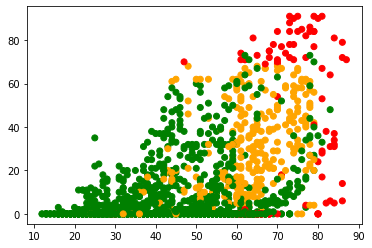

In [85]:
plt.scatter(*X_2f.values.T, c=y_2f.map(diagnosis_color_map))

In [86]:
scaler = StandardScaler()
X_2f = scaler.fit_transform(X_2f)

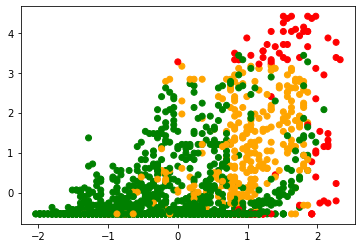

In [87]:
plt.scatter(*X_2f.T, c=y_2f.map(diagnosis_color_map))

In [88]:
model = LogisticRegression(C=1, multi_class="ovr",
    solver="saga",random_state=42)
model.fit(X_2f, y_2f)

LogisticRegression(C=1, multi_class='ovr', random_state=42, solver='saga')

In [89]:
def separator_2d(model, x1, n=0):
    return -x1*model.coef_[n, 0]/model.coef_[n, 1] - model.intercept_[n]/model.coef_[n, 1]

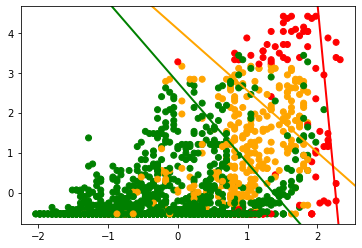

In [90]:
plt.scatter(*X_2f.T, c=y_2f.map(diagnosis_color_map))
xlim, ylim = plt.xlim(), plt.ylim()
for n, c in enumerate(model.classes_):
    sep_x = np.linspace(*xlim, 2)
    sep_y = separator_2d(model, sep_x, n)
    plt.plot(sep_x, sep_y, c=diagnosis_color_map[c], linewidth=2)
plt.xlim(xlim); plt.ylim(ylim);

### Perceptron

In [91]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

**NOTA: Percepetron usa la versione ONE-VERSUS-ALL**. 
Vedi [qui](https://scikit-learn.org/stable/modules/multiclass.html)

Grid search per ottenere i parametri migliori:
- `penalty` (default=`None`): The penalty (aka regularization term) to be used => {‘l2’,’l1’,’elasticnet’}
- `alpha` (default=`0.0001`): Constant that multiplies the regularization term if regularization is used (lambda term in the Moro slides)
- `l1_ratio` (default=`0.15`): The Elastic Net mixing parameter, with `0 <= l1_ratio <= 1`. `l1_ratio=0` corresponds to L2 penalty, `l1_ratio=1` to L1. **Only used if penalty='elasticnet'**.



In [92]:
np.logspace(-2, 3, 6)

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [93]:
params_grid = [
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["none"],
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l2", "l1"],
        "lr__alpha": np.logspace(-2, 2, 5),
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["elasticnet"],
        "lr__alpha": np.logspace(-2, 3, 6),
        "lr__l1_ratio": [0.2, 0.4, 0.6, 0.8],
    }
]

In [94]:
perceptron_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", Perceptron())
])

In [95]:
%%time
perceptron, perceptron_best_params, perceptron_ranking = \
    get_tuned_model(perceptron_model, params_grid, X_train, y_train)

CPU times: user 5.43 s, sys: 25.6 ms, total: 5.46 s
Wall time: 5.46 s


I migliori parametri ottenuti sono:

In [96]:
perceptron_best_params

{'lr__alpha': 0.01,
 'lr__l1_ratio': 0.2,
 'lr__penalty': 'elasticnet',
 'scaler': StandardScaler()}

Le prime 5 combinazioni di parametri che danno miglior score:

In [97]:
perceptron_ranking

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__penalty,param_scaler,param_lr__alpha,param_lr__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
23,0.014084,0.000508,0.002888,0.000756,elasticnet,StandardScaler(),0.01,0.2,"{'lr__alpha': 0.01, 'lr__l1_ratio': 0.2, 'lr__...",0.848592,0.827465,0.848057,0.837456,0.872792,0.846872,0.015110,1
1,0.010875,0.001964,0.002559,0.000551,none,StandardScaler(),NaN,NaN,"{'lr__penalty': 'none', 'scaler': StandardScal...",0.838028,0.911972,0.805654,0.840989,0.830389,0.845406,0.035527,2
3,0.013121,0.003063,0.003392,0.001391,l2,StandardScaler(),0.01,NaN,"{'lr__alpha': 0.01, 'lr__penalty': 'l2', 'scal...",0.806338,0.848592,0.837456,0.826855,0.879859,0.839820,0.024392,3
29,0.014820,0.003717,0.002457,0.000099,elasticnet,StandardScaler(),0.01,0.8,"{'lr__alpha': 0.01, 'lr__l1_ratio': 0.8, 'lr__...",0.781690,0.845070,0.848057,0.837456,0.855124,0.833479,0.026508,4
5,0.011739,0.000759,0.002141,0.000062,l1,StandardScaler(),0.01,NaN,"{'lr__alpha': 0.01, 'lr__penalty': 'l1', 'scal...",0.838028,0.834507,0.805654,0.823322,0.848057,0.829913,0.014478,5


,normale,sospetto,patologico
baseline value,-0.691697,0.000000,1.353227
accelerations,1.957304,-2.516684,-2.502455
fetal_movement,-6.155791,1.311242,0.000000
uterine_contractions,0.768368,-1.016205,-1.963605
light_decelerations,0.000000,-1.356541,0.000000
severe_decelerations,0.000000,0.000000,0.000000
prolongued_decelerations,-1.549281,0.000000,4.761747
abnormal_short_term_variability,-0.565324,1.795664,3.307452
mean_value_of_short_term_variability,0.000000,0.000000,0.000000
percentage_of_time_with_abnormal_long_term_variability,-1.508261,0.577241,0.676052


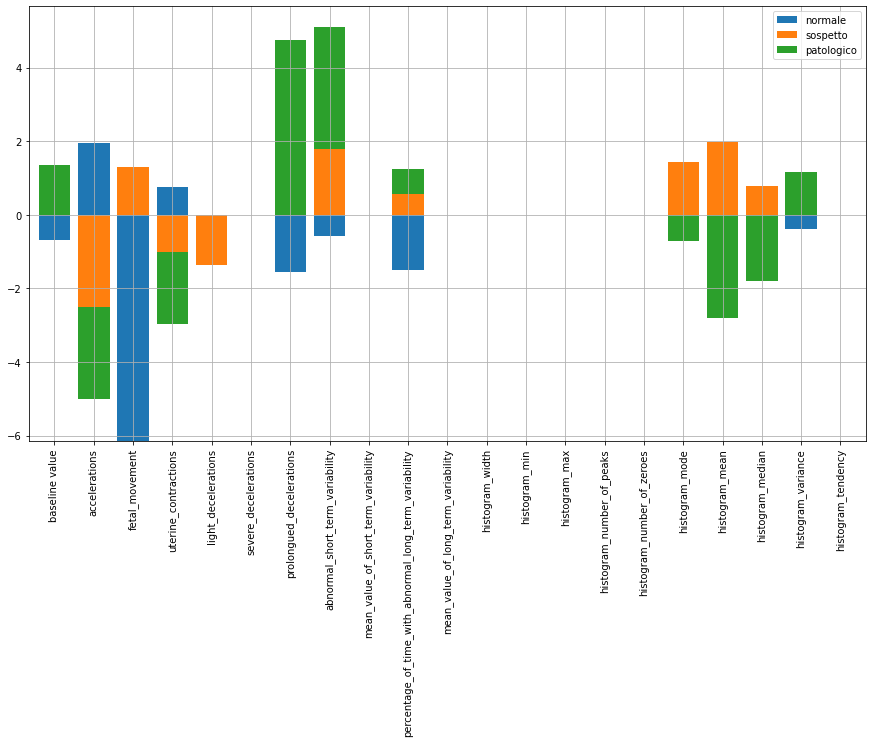

In [98]:
get_features_scores(perceptron)

++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++
> Score: 0.8731 ( 87.31%)

> Intervallo accuratezza (confidenza 95%): (0.8465288162057233, 0.8955715325954691)

> Confusion Matrix: 
     1.0  2.0  3.0
1.0  520   20   20
2.0   28   66   10
3.0    1   11   33

> f1_score per feature: 
[0.93778179 0.65671642 0.61111111]

> f1_score macro: 0.735
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


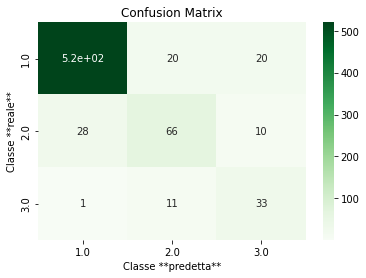

In [99]:
print_eval(X_val, y_val, perceptron)

### Logistic Regression

In [100]:
from sklearn.linear_model import LogisticRegression

In [101]:
params_grid = [
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["none"],
        "lr__multi_class": ["ovr", "multinomial"]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l2", "l1"],
        "lr__C": np.logspace(-2, 3, 6),
        "lr__multi_class": ["ovr", "multinomial"]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["elasticnet"],
        "lr__C": np.logspace(-2, 3, 6),
        "lr__l1_ratio": [0.2, 0.4, 0.6, 0.8],
        "lr__multi_class": ["ovr", "multinomial"]
    }
]

In [102]:
logistic_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(solver="saga"))
])

In [103]:
# %%capture --no-display
%%time
logistic, logistic_best_params, logistic_ranking = \
    get_tuned_model(logistic_model, params_grid, X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

CPU times: user 1min 34s, sys: 501 ms, total: 1min 35s
Wall time: 1min 35s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [104]:
logistic_best_params

{'lr__C': 10.0,
 'lr__multi_class': 'ovr',
 'lr__penalty': 'l2',
 'scaler': StandardScaler()}

In [105]:
logistic_ranking

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__multi_class,param_lr__penalty,param_scaler,param_lr__C,param_lr__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
101,0.270972,0.042806,0.003607,0.000144,ovr,elasticnet,StandardScaler(),10.0,0.2,"{'lr__C': 10.0, 'lr__l1_ratio': 0.2, 'lr__mult...",0.897887,0.887324,0.869258,0.886926,0.908127,0.889904,0.012943,1
29,0.133740,0.003984,0.003871,0.000901,ovr,l2,StandardScaler(),10.0,NaN,"{'lr__C': 10.0, 'lr__multi_class': 'ovr', 'lr_...",0.897887,0.887324,0.869258,0.886926,0.908127,0.889904,0.012943,1
99,0.112389,0.006813,0.004109,0.000681,multinomial,elasticnet,StandardScaler(),1.0,0.8,"{'lr__C': 1.0, 'lr__l1_ratio': 0.8, 'lr__multi...",0.890845,0.880282,0.872792,0.897527,0.904594,0.889208,0.011470,3
27,0.108185,0.001758,0.003540,0.000241,multinomial,l1,StandardScaler(),1.0,NaN,"{'lr__C': 1.0, 'lr__multi_class': 'multinomial...",0.890845,0.883803,0.872792,0.897527,0.901060,0.889205,0.010110,4
109,0.163947,0.005843,0.003042,0.000395,ovr,elasticnet,StandardScaler(),10.0,0.6,"{'lr__C': 10.0, 'lr__l1_ratio': 0.6, 'lr__mult...",0.894366,0.887324,0.869258,0.886926,0.908127,0.889200,0.012580,5


,normale,sospetto,patologico
baseline value,-0.442301,-1.034222,1.945396
accelerations,2.949367,-3.379626,-0.345722
fetal_movement,-0.324246,0.130671,0.483334
uterine_contractions,0.701997,-0.475427,-0.494411
light_decelerations,0.132059,-0.065457,-0.038804
severe_decelerations,0.004447,-0.057325,-0.037976
prolongued_decelerations,-1.376773,0.146000,0.870675
abnormal_short_term_variability,-1.540150,0.872643,1.682617
mean_value_of_short_term_variability,0.365963,-0.061079,-0.695444
percentage_of_time_with_abnormal_long_term_variability,-0.424944,-0.011339,0.831426


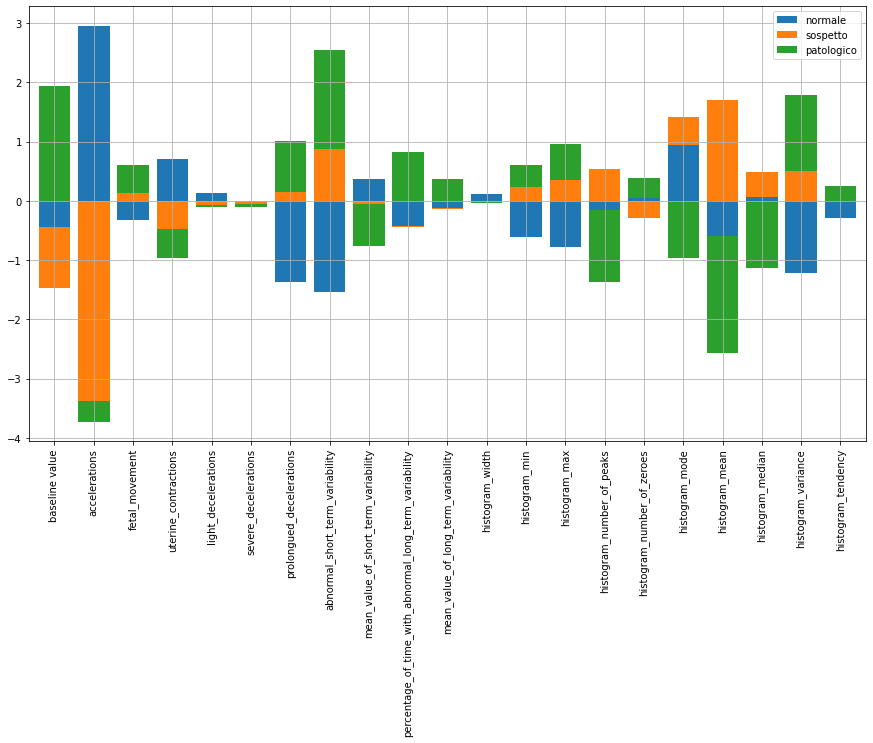

In [106]:
get_features_scores(logistic)

++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++
> Score: 0.8942 ( 89.42%)

> Intervallo accuratezza (confidenza 95%): (0.8694148241183515, 0.9147706106261977)

> Confusion Matrix: 
     1.0  2.0  3.0
1.0  532   23    5
2.0   30   65    9
3.0    3    5   37

> f1_score per feature: 
[0.94577778 0.65989848 0.77083333]

> f1_score macro: 0.792
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


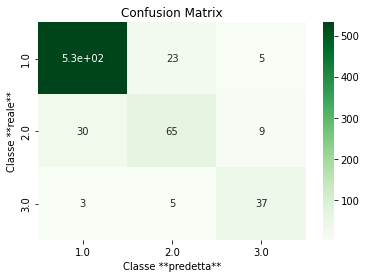

In [107]:
print_eval(X_val, y_val, logistic)

### SVM

In [108]:
from sklearn.svm import LinearSVC

In accordo con la documentazione: 
> **multi_class{‘ovr’, ‘crammer_singer’}, default=’ovr’**.
> 
> Determines the multi-class strategy if y contains more than two classes. "ovr" trains n_classes one-vs-rest classifiers, while "crammer_singer" optimizes a joint objective over all classes. While crammer_singer is interesting from a theoretical perspective as it is consistent, it is seldom used in practice as it rarely leads to better accuracy and is more expensive to compute. If "crammer_singer" is chosen, the options loss, penalty and dual will be ignored.

In [109]:
params_grid = [
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l1"],
        "lr__C": np.logspace(-3, 3, 7),
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l2"],
        "lr__C": np.logspace(-3, 3, 7),
    }
]

In [110]:
svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearSVC(multi_class="ovr", dual=False))
])

In [111]:
svm, svm_best_params, svm_ranking = \
    get_tuned_model(svm_model, params_grid, X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

In [112]:
svm_best_params

{'lr__C': 1000.0, 'lr__penalty': 'l1', 'scaler': None}

In [113]:
svm_ranking

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__penalty,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,0.336386,0.005779,0.003513,0.000527,1000.0,l1,None,"{'lr__C': 1000.0, 'lr__penalty': 'l1', 'scaler...",0.901408,0.883803,0.911661,0.893993,0.865724,0.891318,0.015712,1
19,0.013307,0.000237,0.002443,0.000090,0.1,l2,StandardScaler(),"{'lr__C': 0.1, 'lr__penalty': 'l2', 'scaler': ...",0.897887,0.887324,0.908127,0.893993,0.862191,0.889904,0.015409,2
10,0.344360,0.002869,0.003160,0.000576,100.0,l1,None,"{'lr__C': 100.0, 'lr__penalty': 'l1', 'scaler'...",0.901408,0.883803,0.911661,0.890459,0.862191,0.889904,0.016800,2
13,0.129293,0.018706,0.002697,0.000074,1000.0,l1,StandardScaler(),"{'lr__C': 1000.0, 'lr__penalty': 'l1', 'scaler...",0.894366,0.894366,0.908127,0.893993,0.858657,0.889902,0.016523,4
25,0.014931,0.000162,0.002894,0.000668,100.0,l2,StandardScaler(),"{'lr__C': 100.0, 'lr__penalty': 'l2', 'scaler'...",0.894366,0.894366,0.908127,0.893993,0.858657,0.889902,0.016523,4


,normale,sospetto,patologico
baseline value,-0.005940,-0.010792,0.026666
accelerations,249.779020,-231.279357,-179.205520
fetal_movement,-2.017694,0.668235,3.776288
uterine_contractions,78.726510,-59.138546,-55.363022
light_decelerations,5.293428,-12.786574,34.469175
severe_decelerations,-173.928425,0.000000,0.000000
prolongued_decelerations,-719.189562,48.233912,573.381902
abnormal_short_term_variability,-0.028456,0.013625,0.032598
mean_value_of_short_term_variability,0.149180,-0.020006,-0.238817
percentage_of_time_with_abnormal_long_term_variability,-0.007936,0.000245,0.015300


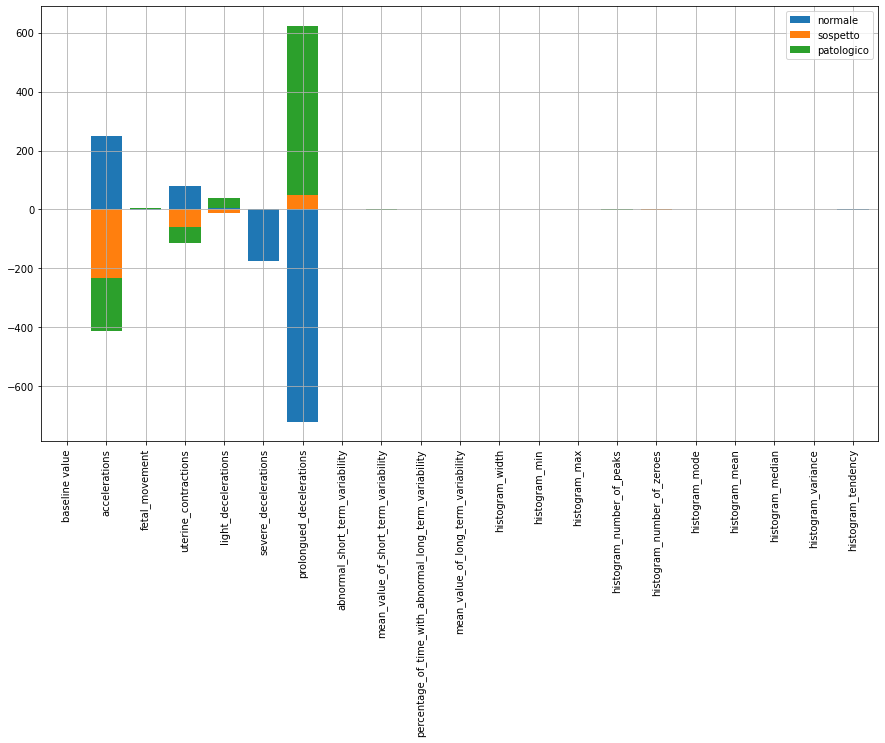

In [114]:
get_features_scores(svm)

++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++
> Score: 0.8928 ( 89.28%)

> Intervallo accuratezza (confidenza 95%): (0.8678811810299564, 0.913498581318369)

> Confusion Matrix: 
     1.0  2.0  3.0
1.0  533   24    3
2.0   30   64   10
3.0    4    5   36

> f1_score per feature: 
[0.945874   0.64974619 0.76595745]

> f1_score macro: 0.787
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


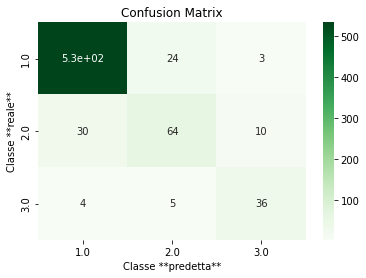

In [115]:
print_eval(X_val, y_val, svm)

### Alberi decisionali

In [116]:
from sklearn.tree import DecisionTreeClassifier

In [117]:
tree_model = Pipeline([
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier())
])

In [118]:
params_grid = {
    "tree__max_depth": [2, 4, 6, 8, 10],
    "tree__min_samples_leaf": np.arange(1, 10),
    "tree__min_samples_split": np.arange(2, 20, 2)
}

In [119]:
tree, tree_best_params, tree_ranking = \
    get_tuned_model(tree_model, params_grid, X_train, y_train)

In [120]:
tree_best_params

{'tree__max_depth': 6,
 'tree__min_samples_leaf': 2,
 'tree__min_samples_split': 2}

In [121]:
tree_ranking

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree__max_depth,param_tree__min_samples_leaf,param_tree__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
171,0.009837,0.000086,0.002153,0.000062,6,2,2,"{'tree__max_depth': 6, 'tree__min_samples_leaf...",0.933099,0.936620,0.918728,0.893993,0.911661,0.918820,0.015417,1
325,0.012531,0.000247,0.002280,0.000059,10,1,4,"{'tree__max_depth': 10, 'tree__min_samples_lea...",0.929577,0.926056,0.922261,0.908127,0.904594,0.918123,0.009942,2
174,0.009764,0.000073,0.002203,0.000153,6,2,8,"{'tree__max_depth': 6, 'tree__min_samples_leaf...",0.933099,0.933099,0.918728,0.893993,0.911661,0.918116,0.014649,3
172,0.009830,0.000094,0.002199,0.000059,6,2,4,"{'tree__max_depth': 6, 'tree__min_samples_leaf...",0.933099,0.936620,0.922261,0.886926,0.911661,0.918113,0.017880,4
173,0.010051,0.000387,0.002264,0.000156,6,2,6,"{'tree__max_depth': 6, 'tree__min_samples_leaf...",0.933099,0.933099,0.918728,0.890459,0.911661,0.917409,0.015833,5


La funzione `get_features_scores(tree)` non funziona :(

++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++
> Score: 0.9351 ( 93.51%)

> Intervallo accuratezza (confidenza 95%): (0.9145414488553758, 0.9510084853796632)

> Confusion Matrix: 
     1.0  2.0  3.0
1.0  545   10    5
2.0   27   76    1
3.0    3    0   42

> f1_score per feature: 
[0.96035242 0.8        0.90322581]

> f1_score macro: 0.888
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


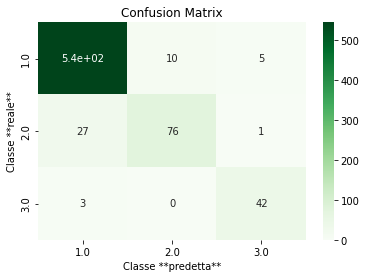

In [122]:
print_eval(X_val, y_val, tree)

### XGBoost

https://xgboost.readthedocs.io/en/stable/python/python_api.html

In [123]:
import xgboost
from xgboost import XGBClassifier

In [124]:
xgb_model = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(nthread=8, objective="multi:softprob"))
])

In [125]:
params_grid = {
    'xgb__eta': [0.002, 0.1, 0.5],
    'xgb__max_depth': [6],
    'xgb__n_estimators': [150, 300],
    'xgb__alpha': [0.0001, 0.001]
}

In [126]:
%%time
xgb, xgb_best_params, xgb_ranking = \
    get_tuned_model(xgb_model, params_grid, X_train, y_train)

CPU times: user 3min 11s, sys: 40.5 s, total: 3min 51s
Wall time: 2min 4s


In [127]:
xgb_best_params

{'xgb__alpha': 0.0001,
 'xgb__eta': 0.002,
 'xgb__max_depth': 6,
 'xgb__n_estimators': 300}

In [128]:
xgb_ranking

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__alpha,param_xgb__eta,param_xgb__max_depth,param_xgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,2.539902,0.037489,0.011516,0.000252,0.0001,0.002,6,300,"{'xgb__alpha': 0.0001, 'xgb__eta': 0.002, 'xgb...",0.957746,0.926056,0.964664,0.943463,0.943463,0.947079,0.01335,1
3,2.539694,0.050155,0.013387,0.003002,0.0001,0.1,6,300,"{'xgb__alpha': 0.0001, 'xgb__eta': 0.1, 'xgb__...",0.957746,0.926056,0.964664,0.943463,0.943463,0.947079,0.01335,1
5,2.535827,0.048610,0.011600,0.000369,0.0001,0.5,6,300,"{'xgb__alpha': 0.0001, 'xgb__eta': 0.5, 'xgb__...",0.957746,0.926056,0.964664,0.943463,0.943463,0.947079,0.01335,1
7,2.532028,0.042761,0.012011,0.000965,0.001,0.002,6,300,"{'xgb__alpha': 0.001, 'xgb__eta': 0.002, 'xgb_...",0.957746,0.926056,0.964664,0.943463,0.943463,0.947079,0.01335,1
9,2.529208,0.051094,0.011861,0.000760,0.001,0.1,6,300,"{'xgb__alpha': 0.001, 'xgb__eta': 0.1, 'xgb__m...",0.957746,0.926056,0.964664,0.943463,0.943463,0.947079,0.01335,1


++++++++++++++++++ PREDICTION ACCURACY STATS ++++++++++++++++++
> Score: 0.9492 ( 94.92%)

> Intervallo accuratezza (confidenza 95%): (0.9305059638918175, 0.9631006943054595)

> Confusion Matrix: 
     1.0  2.0  3.0
1.0  544   13    3
2.0   17   85    2
3.0    1    0   44

> f1_score per feature: 
[0.96969697 0.84158416 0.93617021]

> f1_score macro: 0.916
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


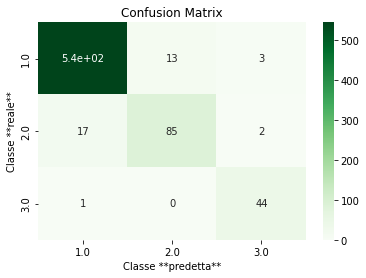

In [129]:
print_eval(X_val, y_val, xgb)

## CLASSIFICAZIONE NON LINEARE

In [130]:
from sklearn.preprocessing import PolynomialFeatures

In [131]:
params_grid = [
    {
        "scaler": [None, StandardScaler()],
        "poly__degree" : [2, 3],
        "lr__penalty": ["none"],
        "lr__multi_class": ["ovr", "multinomial"]
    },
    {
        "scaler": [None, StandardScaler()],
        "poly__degree" : [2, 3],
        "lr__penalty": ["l2", "l1"],
        "lr__C": np.logspace(-2, 3, 6),
        "lr__multi_class": ["ovr", "multinomial"]
    },
    {
        "scaler": [None, StandardScaler()],
        "poly__degree" : [2, 3],
        "lr__penalty": ["elasticnet"],
        "lr__C": np.logspace(-2, 3, 6),
        "lr__l1_ratio": [0.2, 0.4, 0.6, 0.8],
        "lr__multi_class": ["ovr", "multinomial"]
    }
]

In [132]:
poly_logistic_model = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("lr", LogisticRegression(solver="saga"))
])

In [ ]:
%%time
poly_logistic, poly_logistic_best_params, poly_logistic_ranking = \
    get_tuned_model(poly_logistic_model, params_grid, X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

## Confronto tra modelli

In [ ]:
from scipy.stats import norm

In [ ]:
def diff_interval(a1, a2, N1, N2, Z):
    d = abs(a1 - a2)
    sd = np.sqrt(a1 * (1-a1) / N1 + a2 * (1-a2) / N2)
    return d - Z * sd, d + Z * sd

In [ ]:
def model_diff_interval(m1, m2, X, y, level=0.95):
    a1 = m1.score(X, y)
    a2 = m2.score(X, y)
    N = len(X)
    Z = norm.ppf((1+level) / 2)
    return diff_interval(a1, a2, N, N, Z)

In [ ]:
model_names = ["perceptron", "logistic", "poly_logistic", "svm", "tree", "xgb"]
models = [perceptron, logistic, poly_logistic, svm, tree, xgb]
n_models = len(models)

In [ ]:
scores = np.empty((n_models, n_models), dtype=object)
for m1, i in zip(models, range(n_models)):
    for m2, j in zip(models, range(n_models)):
        scores[i, j] = model_diff_interval(m1, m2, X_val, y_val)
scores = np.where(np.tril(scores, -1) == 0, 0, scores)
scores = pd.DataFrame(scores, columns=model_names, index=model_names)

In [ ]:
scores